# Irreducible representations

In [1]:
from su2nn_e3nn_core.su2 import Irreps

In [2]:
# physical vector 
irreps = Irreps("1oe")
irreps

1x1oe

In [3]:
# spin
irreps2 = Irreps("1eo")
irreps2

1x1eo

In [4]:
irreps3 = Irreps("0.5eo")
irreps3

1x1/2eo

In [5]:
# Tuple[Tuple[int, Tuple[int, int]]]
# ((multiplicity, (l, p)), ...)

print(len(irreps))
mul_ir = irreps[0]  # a tuple

print(mul_ir)
print(len(mul_ir))
mul = mul_ir[0]  # an int
ir = mul_ir[1]  # another tuple

print(mul)

print(ir)
# print(len(ir))  ir is a tuple of 2 ints but __len__ has been disabled since it is always 2
l = ir[0]
p = ir[1]

print(l, p)

1
1x1oe
2
1
1oe
1 -1


In [6]:
import torch
t = torch.tensor

# show the transformation matrix corresponding to the inversion
irreps.D_from_angles(alpha=t(0.0), beta=t(0.0), gamma=t(0.0), k=t(1))

tensor([[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -1.+0.j]], dtype=torch.complex128)

In [7]:
# a small rotation around the y axis
irreps.D_from_angles(alpha=t(0.1), beta=t(0.0), gamma=t(0.0), k=t(0))

tensor([[0.9950+0.0998j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 1.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.9950-0.0998j]],
       dtype=torch.complex128)

[]

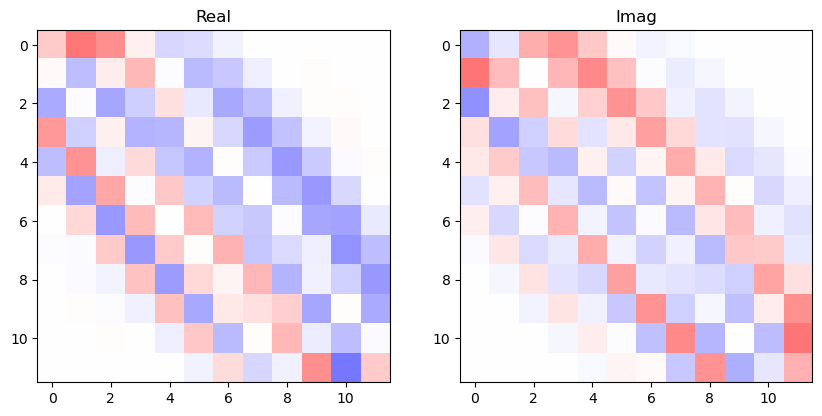

In [32]:
irreps = Irreps("3x0ee + 2x0oe + 1x1eo + 1x2oe")
irreps = Irreps("1x5.5eo")
from su2nn_e3nn_core import su2
rot = -su2.rand_matrix()

D = irreps.D_from_angles(torch.tensor([30]), torch.tensor([50]), torch.tensor([10]))
D = irreps.D_from_matrix(rot)
# print(D)

D = D.reshape(irreps.dim, irreps.dim)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize = (10, 5))
ax1, ax2 = axs[0], axs[1]
ax1.imshow(D.real, cmap='bwr', vmin=-1, vmax=1)
ax1.set_title('Real')
ax2.imshow(D.imag, cmap='bwr', vmin=-1, vmax=1)
ax2.set_title('Imag')
plt.plot()

[]

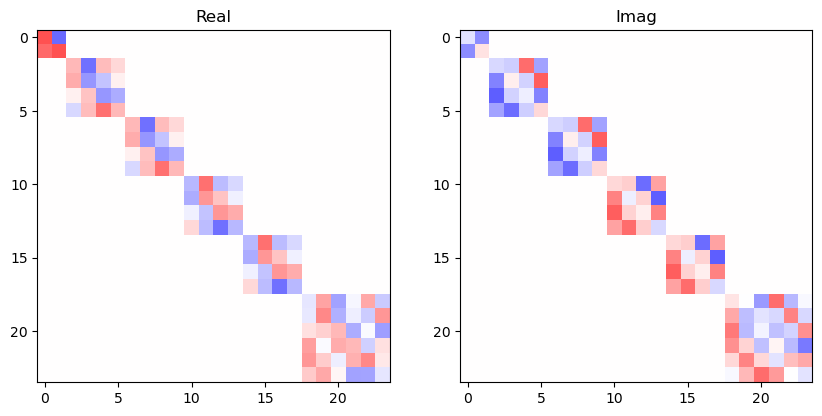

In [20]:
irreps = Irreps("1x0.5ee + 1x1.5ee + 1x1.5eo + 1x1.5oe + 1x1.5oo+ 1x2.5oe")
from su2nn_e3nn_core import su2
rot = -su2.rand_matrix()

D = irreps.D_from_matrix(rot)
# print(D)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize = (10, 5))
ax1, ax2 = axs[0], axs[1]
ax1.imshow(D.real, cmap='bwr', vmin=-1, vmax=1)
ax1.set_title('Real')
ax2.imshow(D.imag, cmap='bwr', vmin=-1, vmax=1)
ax2.set_title('Imag')
plt.plot()

# Convolution

In [10]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from su2nn_e3nn_core import su2, nn
from su2nn_e3nn_core.math import soft_one_hot_linspace
import matplotlib.pyplot as plt

In [11]:
irreps_input = su2.Irreps("10x0ee + 10x1eo")
irreps_output = su2.Irreps("20x0ee + 10x1eo")

In [12]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions

# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]

# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([2814])


28.14

In [13]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions

# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]

# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([3734])


37.34

In [14]:
f_in = irreps_input.randn(num_nodes, -1)

In [15]:
f_in.pow(2).mean()  # should be close to 1

tensor(0.9857)

In [16]:
irreps_sh = su2.Irreps.spherical_harmonics(lmax=2)
print(irreps_sh)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
# normalize=True ensure that x is divided by |x| before computing the sh

sh.pow(2).mean()  # should be close to 1

AttributeError: type object 'Irreps' has no attribute 'spherical_harmonics'

In [ ]:
tp = su2.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

tp.visualize();

# Equivariance check

In [ ]:
import logging

import torch
from torch_cluster import radius_graph
from torch_geometric.data import Data, DataLoader
from torch_scatter import scatter

from su2nn_e3nn_core import su2
from su2nn_e3nn_core.su2 import FullyConnectedTensorProduct
from su2nn_e3nn_core.util.test import assert_equivariant

In [33]:
def data_prep():
    pos = torch.tensor([
        [[0,0,0], [1,0,0], [0,1,0]]
    ])
    spin = torch.tensor([
        [[1,0,0], [1,0,0], [1,0,0]]
    ])
    return pos, spin

In [ ]:
class SU2_Net(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__(irreps_mid, irreps_out)
        self.irreps_sh = Irreps('1x0ee+1x1oe+1x2ee')# su2.Irreps.spherical_harmonics(lmax)
        irreps_mid = irreps_mid
        irreps_out = irreps_out

        self.tp1 = FullyConnectedTensorProduct(
            irreps_in1=self.irreps_sh,
            irreps_in2=self.irreps_sh,
            irreps_out=irreps_mid,
        )
        self.tp2 = FullyConnectedTensorProduct(
            irreps_in1=irreps_mid,
            irreps_in2=self.irreps_sh,
            irreps_out=irreps_out,
        )
        self.irreps_out = self.tp2.irreps_out
    
    def forward():
        num_neighbors = 2  # typical number of neighbors
        num_nodes = 4  # typical number of nodes

        edge_src, edge_dst = radius_graph(x=data.pos, r=1.1, batch=data.batch)  # tensors of indices representing the graph
        edge_vec = data.pos[edge_src] - data.pos[edge_dst]
        edge_sh = s3.spherical_harmonics(
            l=self.irreps_sh,
            x=edge_vec,
            normalize=False,  # here we don't normalize otherwise it would not be a polynomial
            normalization="component",
        )

        # For each node, the initial features are the sum of the spherical harmonics of the neighbors
        node_features = scatter(edge_sh, edge_dst, dim=0).div(num_neighbors**0.5)

        # For each edge, tensor product the features on the source node with the spherical harmonics
        edge_features = self.tp1(node_features[edge_src], edge_sh)
        node_features = scatter(edge_features, edge_dst, dim=0).div(num_neighbors**0.5)

        edge_features = self.tp2(node_features[edge_src], edge_sh)
        node_features = scatter(edge_features, edge_dst, dim=0).div(num_neighbors**0.5)

        # For each graph, all the node's features are summed
        return scatter(node_features, data.batch, dim=0).div(num_nodes**0.5)

In [ ]:
def main():
    data, labels = data_prep()
    f = SU2_Net()

    optim = torch.optim.Adam(f.parameters(), lr=1e-2)

    # == Train ==
    for step in range(200):
        pred = f(data)
        loss = (pred - labels).pow(2).sum()

        optim.zero_grad()
        loss.backward()
        optim.step()

        if step % 10 == 0:
            accuracy = pred.round().eq(labels).all(dim=1).double().mean(dim=0).item()
            print(f"epoch {step:5d} | loss {loss:<10.1f} | {100 * accuracy:5.1f}% accuracy")

    # == Check equivariance ==
    # Because the model outputs (psuedo)scalars, we can easily directly
    # check its equivariance to the same data with new rotations:
    print("Testing equivariance directly...")
    rotated_data, _ = tetris()
    error = f(rotated_data) - f(data)
    print(f"Equivariance error = {error.abs().max().item():.1e}")

    print("Testing equivariance using `assert_equivariance`...")
    # We can also use the library's `assert_equivariant` helper
    # `assert_equivariant` also tests parity and translation, and
    # can handle non-(psuedo)scalar outputs.
    # To "interpret" between it and torch_geometric, we use a small wrapper:

    def wrapper(pos, batch):
        return f(Data(pos=pos, batch=batch))

    # `assert_equivariant` uses logging to print a summary of the equivariance error,
    # so we enable logging
    logging.basicConfig(level=logging.INFO)
    assert_equivariant(
        wrapper,
        # We provide the original data that `assert_equivariant` will transform...
        args_in=[data.pos, data.batch],
        # ...in accordance with these irreps...
        irreps_in=[
            "cartesian_points",  # pos has vector 1o irreps, but is also translation equivariant
            None,  # `None` indicates invariant, possibly non-floating-point data
        ],
        # ...and confirm that the outputs transform correspondingly for these irreps:
        irreps_out=[f.irreps_out],
    )


In [ ]:
main()

In [ ]:
def test():
    data, labels = data_prep()
    f = InvariantPolynomial()

    pred = f(data)
    loss = (pred - labels).pow(2).sum()
    loss.backward()

    rotated_data, _ = tetris()
    error = f(rotated_data) - f(data)
    assert error.abs().max() < 1e-5

In [ ]:
test()